## Emotion Classification using LSTM and Word2Vec

## Workflow: 
1. Import Data
2. Prepare the input data
3. Import pretrained word vectors
4. Create LSTM Pipeline
5. Train The Model
6. Evaluation
7. Kaggle data

## 1. Import Data


In [1]:
import pandas as pd
import numpy as np

# text preprocessing
from nltk.tokenize import word_tokenize
import re

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# preparing input to our model
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from keras.layers import Bidirectional, LSTM, GRU, Dense

In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.device('/GPU:0')

Defining vector space dimension and fixed input size

In [4]:
# Number of labels
num_classes = 6

# Number of dimensions for word embedding
embed_num_dims = 300

# Max input length (max number of words) 
max_seq_len = 500

class_names = ['happiness', 'sadness', 'anger', 'fear', 'surprise', 'disgust']

Importing the dataset to split into training and testing set

In [5]:
data = pd.read_csv('final_concatenated.csv')
data

,sentence,emotion
0,"angstrom the curtains drew back, revealing a s...",surprise
1,"As the drapery drew back, revealing a stage ba...",surprise
2,"As the curtains Drew back, revealing a stage b...",surprise
3,"unfold the mysterious package, she discovered ...",surprise
4,"Opening the deep package, she discovered a lon...",surprise
...,...,...
152926,"Oh yeah, she didn't hire me out of pity, it wa...",happiness
152927,"Wow! And hey, it's cool if you're a lesbian!",happiness
152928,"Oh yeah, I totally agree.",happiness
152929,...I think he deserves a Nobel Prize.,happiness


In [6]:
# Assuming 'df' is your DataFrame
# This line drops rows where the 'sentence' column has NaN values
data = data.dropna(subset=['sentence'])

data = data[data["emotion"] != "neutral"]

# Now, 'df' will only contain rows where the 'sentence' column is not NaN
data

,sentence,emotion
0,"angstrom the curtains drew back, revealing a s...",surprise
1,"As the drapery drew back, revealing a stage ba...",surprise
2,"As the curtains Drew back, revealing a stage b...",surprise
3,"unfold the mysterious package, she discovered ...",surprise
4,"Opening the deep package, she discovered a lon...",surprise
...,...,...
152926,"Oh yeah, she didn't hire me out of pity, it wa...",happiness
152927,"Wow! And hey, it's cool if you're a lesbian!",happiness
152928,"Oh yeah, I totally agree.",happiness
152929,...I think he deserves a Nobel Prize.,happiness


In [7]:
data.value_counts('emotion')

emotion
anger          28913
happiness      27316
fear           26673
sadness        25340
disgust        23202
surprise       21467
happiness         20
Name: count, dtype: int64

In [8]:
# Rename all 'sadness' to 'happiness'	
data['emotion'] = data['emotion'].replace('happiness  ', 'happiness')

In [9]:
data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)

In [10]:
df_train_cleaned = data_train.dropna(subset=['emotion'])

In [11]:
df_test_cleaned = data_test.dropna(subset=['emotion'])

In [12]:
X_train = df_train_cleaned['sentence']
X_test = df_test_cleaned['sentence']
y_train = df_train_cleaned['emotion']
y_test = df_test_cleaned['emotion']

In [13]:

print("\n\nTraining set:", len(X_train))
print("\nTesting set:", len(X_test))



Training set: 122344

Testing set: 30587


<Axes: xlabel='emotion'>

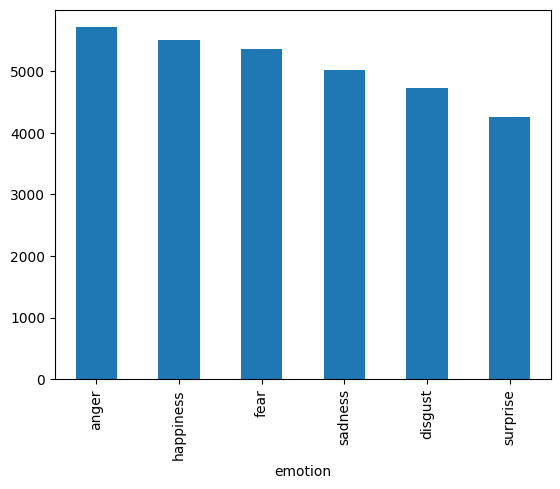

In [14]:
y_test.value_counts().plot(kind='bar')

<Axes: xlabel='emotion'>

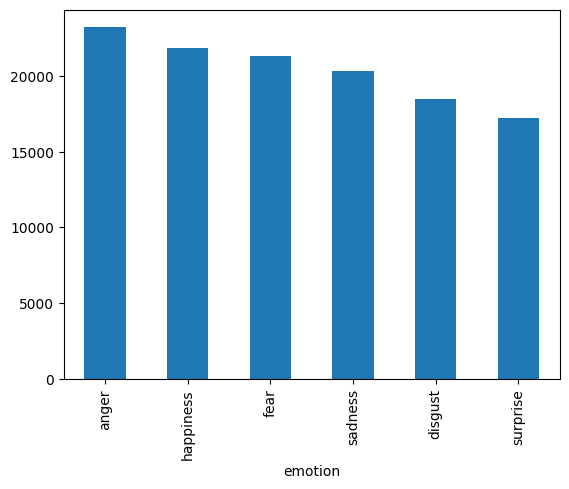

In [15]:
y_train.value_counts().plot(kind='bar')

## 2. Prepare input data

In [16]:
def clean_text(data):
    
    # remove hashtags and @usernames
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    
    # tekenization using nltk
    data = word_tokenize(data)
    
    return data

In [17]:
texts = [' '.join(clean_text(text)) for text in data.sentence]

In [18]:
texts_train = [' '.join(clean_text(text)) for text in X_train]

In [19]:
texts_test = [' '.join(clean_text(text)) for text in X_test]

In [20]:
print(texts_test[74])

I started crying when I lost my bag .


**Tokenization + fitting using keras**

In [21]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

# vacab size is number of unique words + reserved 0 index for padding
vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 33612


**Padding** 

In [22]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[   0,    0,    0, ...,  652,  518, 1512],
       [   0,    0,    0, ...,   24,    2,  804],
       [   0,    0,    0, ...,    8,    2,  284],
       ...,
       [   0,    0,    0, ...,  127,    6,   83],
       [   0,    0,    0, ...,    8,  149,  986],
       [   0,    0,    0, ...,   31,  814,  265]])

**Categorize** labels: 

In [23]:
encoding = {
    'happiness': 0,
    'sadness': 1,
    'anger': 2,
    'fear': 3,
    'surprise': 4,
    'disgust': 5
}

In [24]:
# Use the map function to transform each emotion to its corresponding integer encoding
y_train_encoded = y_train.map(encoding)

# Or
y_train_array = y_train_encoded.to_numpy()

# y_train_array is now an array of integers representing the emotions according to your encoding
y_train_array

array([4, 3, 0, ..., 5, 0, 4], dtype=int64)

In [25]:
# Use the map function to transform each emotion to its corresponding integer encoding
y_test_encoded = y_test.map(encoding)

# Or
y_test_array = y_test_encoded.to_numpy()

# y_train_array is now an array of integers representing the emotions according to your encoding
y_test_array


array([3, 5, 3, ..., 2, 2, 1], dtype=int64)

In [26]:
y_train.unique()

array(['surprise', 'fear', 'happiness', 'disgust', 'anger', 'sadness'],
      dtype=object)

In [27]:
# Integer labels
y_train = [encoding[x] for x in df_train_cleaned.emotion]
y_test = [encoding[x] for x in df_test_cleaned.emotion]

In [28]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]], dtype=float32)

## 3. Import pretrained word vectors

In [29]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

300 dimentional w2v pre-trained on wikipedia articles: https://fasttext.cc/docs/en/english-vectors.html

In [30]:
import urllib.request
import zipfile
import os
import numpy as np

fname = 'embeddings/wiki-news-300d-1M.vec'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve(
        'https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
        'wiki-news-300d-1M.vec.zip'
    )
    print('Unzipping...')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')
    
    os.remove('wiki-news-300d-1M.vec.zip')

def create_embedding_matrix(filepath, word_index, embedding_dim):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    with open(filepath, encoding='utf-8') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

# Define the missing variables or use the existing ones correctly
embedding_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims)

# Now you can safely access embedding_matrix
new_words = 0
for word in index_of_words:
    entry = embedding_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words += 1

# Output the results
print('Words found in crawl vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in crawl vocab: 29365
New words found: 4247


## 4. Create RNN Pipeline

In [32]:
# Embedding layer before the actaul BLSTM 
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedding_matrix],
                         trainable=False)

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

# Assuming 'embedd_layer' is your pre-defined embedding layer
model = Sequential()
model.add(embedd_layer)  # Your pre-defined embedding layer

# RNN layer(s)
model.add(SimpleRNN(128, return_sequences=True))
model.add(Dropout(0.2))

model.add(SimpleRNN(64))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(num_classes, activation='softmax')) 


In [34]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          10083900  
                                                                 
 simple_rnn (SimpleRNN)      (None, 500, 128)          54912     
                                                                 
 dropout (Dropout)           (None, 500, 128)          0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 10,151,554
Trainable params: 67,654
Non-tr

## 5. Train the Model

In [35]:
X_train_pad.shape, y_train.shape

((122344, 500), (122344, 6))

In [36]:
from keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)  # Stop training if validation loss doesn't improve for 3 epochs

In [37]:
batch_size = 1024
epochs = 6

# Train the model with early stopping
hist = model.fit(X_train_pad, y_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad, y_test),
                 callbacks=[early_stopping])


Epoch 1/6
120/120 [==============================] - 233s 2s/step - loss: 1.5209 - accuracy: 0.3822 - val_loss: 1.0938 - val_accuracy: 0.5968
Epoch 2/6
120/120 [==============================] - 188s 2s/step - loss: 1.0291 - accuracy: 0.6338 - val_loss: 0.9149 - val_accuracy: 0.6772
Epoch 3/6
120/120 [==============================] - 287s 2s/step - loss: 0.9753 - accuracy: 0.6589 - val_loss: 0.8962 - val_accuracy: 0.6839
Epoch 4/6
120/120 [==============================] - 165s 1s/step - loss: 0.9303 - accuracy: 0.6751 - val_loss: 0.9432 - val_accuracy: 0.6670
Epoch 5/6
120/120 [==============================] - 93s 773ms/step - loss: 1.1168 - accuracy: 0.5992 - val_loss: 1.1141 - val_accuracy: 0.5964


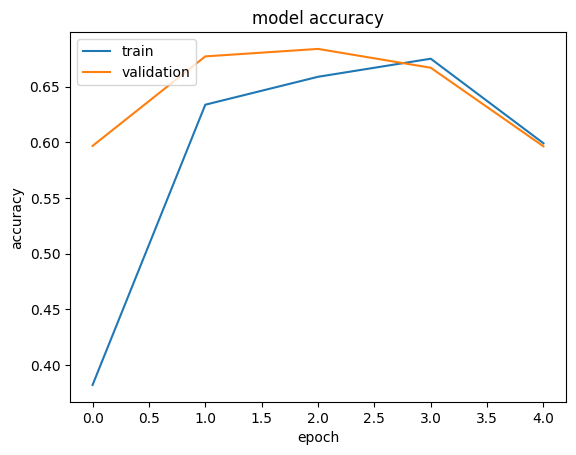

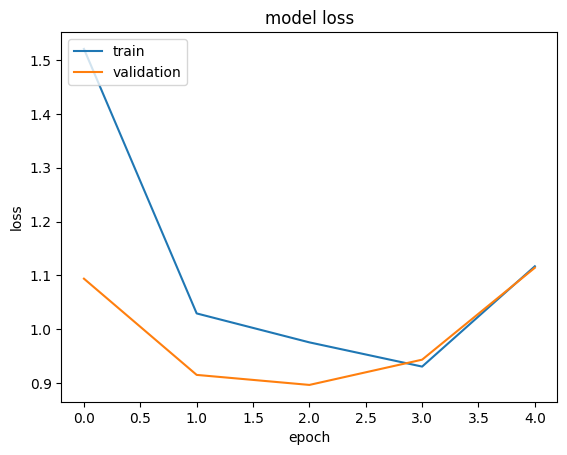

In [38]:
# Accuracy plot
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## 6. Evaluation

In [39]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

956/956 [==============================] - 102s 106ms/step


In [40]:
print("Accuracy: {:.2f}%".format(accuracy_score(df_test_cleaned.emotion, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df_test_cleaned.emotion, predictions, average='micro') * 100))

Accuracy: 68.39%

F1 Score: 68.39


#### Plotting confusion Matrix:

In [41]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


F1 Score: 68.39


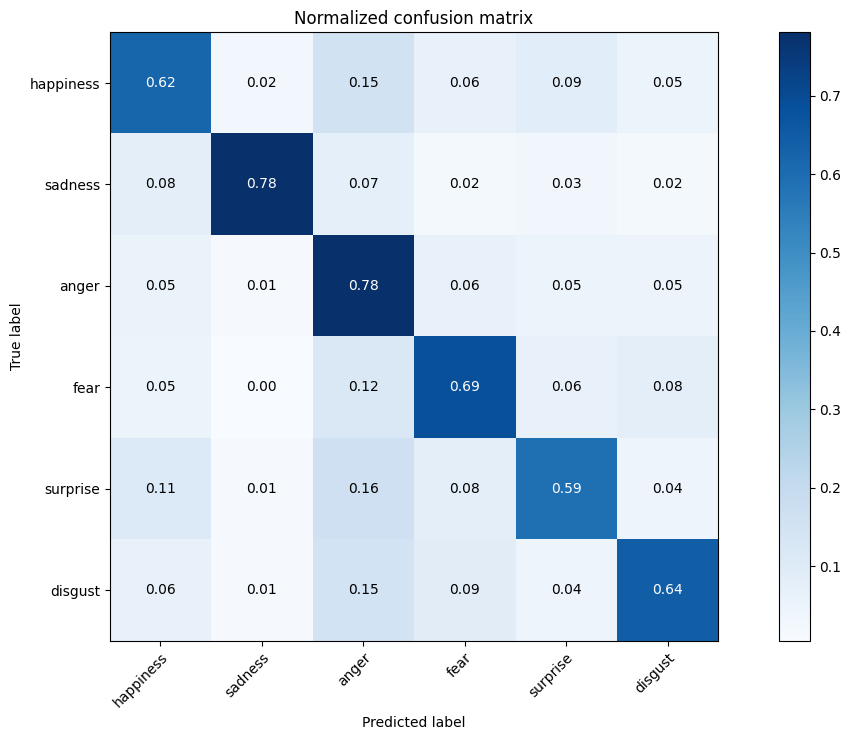

In [42]:
print("\nF1 Score: {:.2f}".format(f1_score(df_test_cleaned.emotion, predictions, average='micro') * 100))

# Plot normalized confusion matrix
plot_confusion_matrix(df_test_cleaned.emotion, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

## 7. Kaggle data

In [43]:
import time

message = ['I am so sad at you!']

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = model.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

1/1 [==============================] - 0s 130ms/step
Message: ['I am so sad at you!']
predicted: sadness (0.18 seconds)


In [44]:
kaggle_data = pd.read_csv('group_test.csv', sep='\t')
kaggle_data

,id,sentence
0,0,Girls are happy when they get flowers
1,1,His jaw dropped in disbelief when he saw the p...
2,2,Sometimes the ugly stench makes me wanna throw...
3,3,The foul odor from the garbage bin was disgust...
4,4,"I can’t believe it, they lost the game in the ..."
...,...,...
1431,1431,I feel guilty about the ice cream I stole as a...
1432,1432,Her ability to recall obscure facts never ceas...
1433,1433,"Your cat is so cute, I love him."
1434,1434,She remained skeptical about the new product.


In [45]:
# Function to predict emotion for a given sentence
def predict_emotion(sentence):
    seq = tokenizer.texts_to_sequences([sentence])
    padded = pad_sequences(seq, maxlen=max_seq_len)
    pred = model.predict(padded, verbose = 0)
    return class_names[np.argmax(pred)]

In [46]:
# Apply predict_emotion function to each sentence in the DataFrame
kaggle_data['emotion'] = kaggle_data['sentence'].apply(predict_emotion)

In [47]:
kaggle_data.value_counts('emotion')

emotion
fear         310
happiness    250
anger        245
sadness      218
surprise     209
disgust      204
Name: count, dtype: int64

In [48]:
kaggle_data

,id,sentence,emotion
0,0,Girls are happy when they get flowers,happiness
1,1,His jaw dropped in disbelief when he saw the p...,surprise
2,2,Sometimes the ugly stench makes me wanna throw...,disgust
3,3,The foul odor from the garbage bin was disgust...,disgust
4,4,"I can’t believe it, they lost the game in the ...",sadness
...,...,...,...
1431,1431,I feel guilty about the ice cream I stole as a...,happiness
1432,1432,Her ability to recall obscure facts never ceas...,surprise
1433,1433,"Your cat is so cute, I love him.",happiness
1434,1434,She remained skeptical about the new product.,fear


In [49]:
# Creating new dataframe without the sentence column:
kaggle_submission = kaggle_data.drop('sentence', axis=1)

In [50]:
kaggle_submission.value_counts('emotion')

emotion
fear         310
happiness    250
anger        245
sadness      218
surprise     209
disgust      204
Name: count, dtype: int64

In [51]:
kaggle_submission.to_csv('RNN_final_model.csv', index=False)

In [52]:
# creates a HDF5 file 'my_model.h5'
model.save('RNN_final.h5')